In [261]:
import matplotlib.pyplot as plt

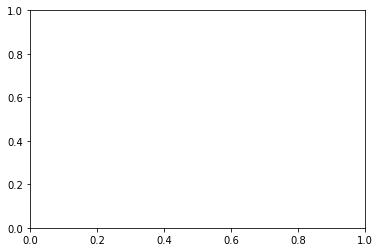

In [265]:
fig, ax = plt.subplots()

In [266]:
x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

<Figure size 432x288 with 0 Axes>

In [274]:
import seaborn as sns

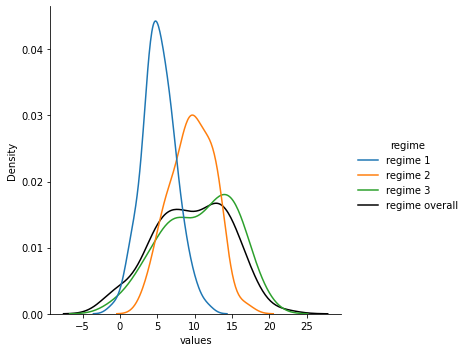

In [312]:
import seaborn as sns

a1 = np.random.normal(5, 2, size=100)
a2 = np.random.normal(10, 3, size=100)
a3 = np.random.normal(15, 2, size=20)
a4 = np.random.normal(10, 5, size=300)

regime_1 = ['regime 1'] * 100
regime_2 = ['regime 2'] * 100
regime_3 = ['regime 3'] * 100
regime_overall = ['regime overall'] * 100

a = np.concatenate([a1, a2, a3, a4])
regime = np.concatenate([regime_1, regime_2, regime_3, regime_overall])

df = pd.DataFrame([a, regime]).T
df.columns = ['values', 'regime']

# change the color that are more 'white' if I want to change the opacity
palette ={"regime 1": "C0", "regime 2": "C1", "regime 3": "C2", "regime overall": "k"}
sns.displot(df, x='values', hue='regime', kind='kde', palette=palette);

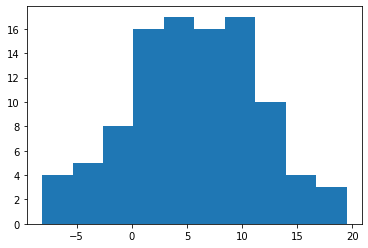

In [272]:
sns.displot(penguins, x="flipper_length_mm", hue="species", kind="kde")


In [1]:
import os

path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [5]:
import pandas as pd
import numpy as np
from app.utils.visualization import plot_data
from app.utils.fetch_data import fred_fred, investing_api, alpha_vantage_api, FMP, alpha_vantage_api_financial_statements
import investpy
from datetime import datetime, date
from scipy.stats import pearsonr
import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)

In [132]:
start_date = '2015-01-01'
today = date.today().strftime("%Y-%m-%d")

print("Analysis from {} to {}".format(start_date, today))

Analysis from 2015-01-01 to 2022-09-08


### 1. Data prep

interest rate
- Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10)
- Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (DGS1)

FED interest rate
- Federal Funds Effective Rate (DFF)

inflation rate
- Invesco DB Commodity Index Tracking Fund (DBC) as a proxy for commodity index
- 10-Year Breakeven Inflation Rate (T10YIE)
- 5-Year Breakeven Inflation Rate (T5YIE)

inflation expectation
- 5-Year, 5-Year Forward Inflation Expectation Rate (T5YIFR)
- University of Michigan: Inflation Expectation (MICH)

dollar index
- dollar index (DXY)

labor
- forward fill monthly `UNRATENSA` data (no daily data)
- Unemployment Rate (UNRATENSA)

economic growth
- forward fill monthly `USALORSGPNOSTSAM` data (no daily data)
- Leading Indicators OECD: Reference series: Gross Domestic Product (GDP): Normalised for the United States (USALORSGPNOSTSAM) - seasonally adjusted

spending
- Personal Consumption Expenditures (PCE) - seasonally adjusted

saving
- Personal Saving (PMSAVE) - seasonally adjusted

debt
- Consumer Loans: Credit Cards and Other Revolving Plans, All Commercial Banks (CCLACBM027NBOG)
- Commercial and Industrial Loans, All Commercial Banks (BUSLOANSNSA)

In [133]:
df_dict = dict()

df_dict['ir10y'] = fred_fred('DGS10', start_date, today) # percent
df_dict['ir1y'] = fred_fred('DGS1', start_date, today) # percent
df_dict['fed_ir'] = fred_fred('DFF', start_date, today) # percent

df_dict['cpi'] = fred_fred('CPALTT01USM657N', start_date, today) # growth rate previous period
df_dict['inflation10y'] = fred_fred('T10YIE', start_date, today) # percent
df_dict['inflation5y'] = fred_fred('T5YIE', start_date, today) # percent
df_dict['dollar_index'] = investing_api("index", 'DXY', start_date, today)

df_dict['inflation_exp'] = fred_fred('MICH', start_date, today) # percent

df_dict['unemp_rate'] = fred_fred('UNRATENSA', start_date, today) # percent

df_dict['spending'] = fred_fred('PCE', start_date, today)
df_dict['consumer_loan'] = fred_fred('CCLACBM027NBOG', start_date, today)
df_dict['commercial_loan'] = fred_fred('BUSLOANSNSA', start_date, today)

2022-09-08 14:55:36,414 [app.utils.fetch_data] [INFO] Fetching data from fred: DGS10, from 2015-01-01 to 2022-09-08.
2022-09-08 14:55:37,518 [app.utils.fetch_data] [INFO] Fetching data from fred: DGS1, from 2015-01-01 to 2022-09-08.
2022-09-08 14:55:38,397 [app.utils.fetch_data] [INFO] Fetching data from fred: DFF, from 2015-01-01 to 2022-09-08.
2022-09-08 14:55:39,668 [app.utils.fetch_data] [INFO] Fetching data from fred: CPALTT01USM657N, from 2015-01-01 to 2022-09-08.
2022-09-08 14:55:40,287 [app.utils.fetch_data] [INFO] Fetching data from fred: T10YIE, from 2015-01-01 to 2022-09-08.
2022-09-08 14:55:41,137 [app.utils.fetch_data] [INFO] Fetching data from fred: T5YIE, from 2015-01-01 to 2022-09-08.
2022-09-08 14:55:42,709 [app.utils.fetch_data] [INFO] Fetching daily index from investing_api: DXY, from 01/01/2015 to 08/09/2022
2022-09-08 14:55:42,721 [app.utils.fetch_data] [INFO] Fetching data from fred: MICH, from 2015-01-01 to 2022-09-08.
2022-09-08 14:55:43,434 [app.utils.fetch_dat

In [134]:
sp500 = investing_api("index", 'SPX', start_date, today, interval='daily')

2022-09-08 14:55:47,370 [app.utils.fetch_data] [INFO] Fetching daily index from investing_api: SPX, from 01/01/2015 to 08/09/2022


### 2. EDA

In [135]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['inflation_exp'], 'Date', 'v', 'Inflation expectation', True]])

In [136]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['cpi'], 'Date', 'v', 'consumer price index', True]])

In [137]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['fed_ir'], 'Date', 'v', 'Fed base rate', True]])

In [138]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['ir10y'], 'Date', 'v', '10 year interest rate', True],
           ['line', df_dict['ir1y'], 'Date', 'v', '1 year interest rate', True]])

In [139]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['dollar_index'], 'Date', 'Close', 'Dollar index', True]])

In [140]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['consumer_loan'], 'Date', 'v', 'consumer loan', True]])

In [141]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['commercial_loan'], 'Date', 'v', 'commercial loan', True]])

In [142]:
plot_data([['line', sp500, 'Date', 'Close', 'S&P500', False],
           ['line', df_dict['spending'], 'Date', 'v', 'spending', True]])

### 3. Model data prep

In [228]:
# master dataset
master_df = sp500[['Date', 'Close']].rename(columns={'Close':"v_sp500"})
master_df['Date_month'] = master_df.Date.astype(str).str.slice(stop=7)
master_df['Date_month'] = pd.to_datetime(master_df['Date_month'], format='%Y-%m')
indices = [master_df.loc[master_df.Date_month==i].index.min() for i in master_df.Date_month.unique()]
master_df.loc[list(set(master_df.index) - set(indices)), 'Date_month'] = np.nan

# merge all the indicators into one table
for i in df_dict.keys():
    if 'v' in df_dict[i].columns:
        tmp_df = df_dict[i][['Date', 'v']].rename(columns={"v":"v_"+i})
    else:
        tmp_df = df_dict[i][['Date', 'Close']].rename(columns={"Close":"v_"+i})
    
    interval = df_dict[i].interval.unique()[0]
    if interval == 'daily':
        master_df = pd.merge(master_df, tmp_df, on='Date', how='left')
        text = "Daily data {} merged.".format(i)
    elif interval == 'monthly':
        master_df = pd.merge(master_df, tmp_df.rename(columns={"Date":"Date_month"}) , on='Date_month', how='left')
        # interpolate linearly
        master_df["v_"+i] = master_df["v_"+i].interpolate(method='linear')
        text = "Monthly data {} merged.".format(i)
        
#     print(text)

master_df.drop(columns=['Date_month'], inplace=True)

In [213]:
master_df.columns

Index(['Date', 'v_sp500', 'v_ir10y', 'v_ir1y', 'v_cpi', 'v_inflation10y',
       'v_inflation5y', 'v_dollar_index', 'v_inflation_exp', 'v_unemp_rate',
       'v_spending', 'v_consumer_loan', 'v_commercial_loan', 'predictions',
       'error_term', 'error_term_predictions', 'prediction_adds'],
      dtype='object')

In [229]:
scale_targets = ['v_sp500', 'v_ir10y', 'v_ir1y', 'v_cpi', 'v_inflation10y',
       'v_inflation5y', 'v_dollar_index', 'v_inflation_exp', 'v_unemp_rate',
       'v_spending', 'v_consumer_loan', 'v_commercial_loan']

scaler = preprocessing.StandardScaler()
scaler.fit(master_df[scale_targets])

scaled_values = scaler.transform(master_df[scale_targets])
scaled_df = pd.DataFrame(scaled_values, columns=[i+'_scaled' for i in scale_targets])

scaled_df.head(3)

,v_sp500_scaled,v_ir10y_scaled,v_ir1y_scaled,v_cpi_scaled,v_inflation10y_scaled,v_inflation5y_scaled,v_dollar_index_scaled,v_inflation_exp_scaled,v_unemp_rate_scaled,v_spending_scaled,v_consumer_loan_scaled,v_commercial_loan_scaled
0,-1.097971,0.165566,-0.909718,-2.000854,-0.480827,-0.919628,-1.403783,-0.655866,0.628126,-1.429873,-1.702389,-1.757553
1,-1.144500,0.045484,-0.898878,-1.882515,-0.660960,-1.007759,-1.320422,-0.639213,0.619918,-1.428237,-1.712157,-1.753600
2,-1.166726,-0.059588,-0.909718,-1.764176,-0.866825,-1.166395,-1.287078,-0.622560,0.611710,-1.426600,-1.721926,-1.749648


In [230]:
master_df = pd.concat([master_df, scaled_df], axis=1)
master_df.head(2)

,Date,v_sp500,v_ir10y,v_ir1y,v_cpi,v_inflation10y,v_inflation5y,v_dollar_index,v_inflation_exp,v_unemp_rate,v_spending,v_consumer_loan,v_commercial_loan,v_sp500_scaled,v_ir10y_scaled,v_ir1y_scaled,v_cpi_scaled,v_inflation10y_scaled,v_inflation5y_scaled,v_dollar_index_scaled,v_inflation_exp_scaled,v_unemp_rate_scaled,v_spending_scaled,v_consumer_loan_scaled,v_commercial_loan_scaled
0,2015-01-02,2058.20,2.12,0.25,-0.470589,1.71,1.30,91.08,2.500,6.100,12036.50,639.66800,1784.400400,-1.097971,0.165566,-0.909718,-2.000854,-0.480827,-0.919628,-1.403783,-0.655866,0.628126,-1.429873,-1.702389,-1.757553
1,2015-01-05,2020.58,2.04,0.26,-0.425345,1.64,1.25,91.38,2.515,6.085,12038.83,638.99467,1785.530625,-1.144500,0.045484,-0.898878,-1.882515,-0.660960,-1.007759,-1.320422,-0.639213,0.619918,-1.428237,-1.712157,-1.753600


In [231]:
master_test_df = master_df.loc[master_df.Date.between('2022-01-01', '2022-06-01')]
master_df = master_df.loc[master_df.Date<'2022-01-01']

### 4. Modeling

1. Modeling with monthly data.
2. Modeling with daily data. The target is the residuals.
3. See if 

In [232]:
monthly_columns = ['v_cpi_scaled', 'v_inflation_exp_scaled', 'v_unemp_rate_scaled', 
                          'v_spending_scaled', 'v_consumer_loan_scaled', 'v_commercial_loan_scaled']
target = ['v_sp500_scaled']
monthly_data = master_df[monthly_columns+target]

train_m_x, test_m_x, train_m_y, test_m_y = train_test_split(monthly_data.loc[:, monthly_columns],
                                                            monthly_data.loc[:, 'v_sp500_scaled'], 
                                                            test_size=0.2, random_state=123)

In [233]:
train_mds = lgb.Dataset(train_m_x, label = train_m_y) 
test_mds = lgb.Dataset(test_m_x, label = test_m_y)

In [234]:
daily_columns = ['v_ir10y_scaled', 'v_ir1y_scaled', 'v_inflation10y_scaled', 
                        'v_inflation5y_scaled', 'v_dollar_index_scaled']
target = ['v_sp500_scaled']
daily_data = master_df[daily_columns+target]

train_d_x, test_d_x, train_d_y, test_d_y = train_test_split(daily_data.loc[:, daily_columns],
                                                            daily_data.loc[:, 'v_sp500_scaled'], 
                                                            test_size=0.2, random_state=123)
train_dds = lgb.Dataset(train_d_x, label = train_d_y) 
test_dds = lgb.Dataset(test_d_x, label = test_d_y)

Train monthly basis model

In [235]:
param = {'objective': 'regression',
         'metric': ['mape', 'mse']}
bst = lgb.train(param, train_mds, 1000, test_mds, callbacks=[lgb.early_stopping(100),lgb.log_evaluation(100)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 6
[LightGBM] [Info] Start training from score -0.167304
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.0233142	valid_0's l2: 0.00138572
[200]	valid_0's mape: 0.0218842	valid_0's l2: 0.0012767
[300]	valid_0's mape: 0.0215586	valid_0's l2: 0.00126046
Early stopping, best iteration is:
[268]	valid_0's mape: 0.0216366	valid_0's l2: 0.00125823


In [236]:
master_df['predictions'] = bst.predict(master_df[monthly_columns])

print("Prediction on past years")
plot_data([['line', master_df, 'Date', 'v_sp500_scaled', 'S&P500', False],
           ['line', master_df, 'Date', 'predictions', 'predictions', False]])

Prediction on past years


In [237]:
master_test_df['predictions'] = bst.predict(master_test_df[monthly_columns])

print("Prediction on 2022")
plot_data([['line', master_test_df, 'Date', 'v_sp500_scaled', 'S&P500', False],
           ['line', master_test_df, 'Date', 'predictions', 'predictions', False]])

Prediction on 2022


Train daily basis model

In [238]:
param = {'objective': 'regression',
         'metric': ['mape', 'mse']}
bst = lgb.train(param, train_dds, 1000, test_dds, callbacks=[lgb.early_stopping(100),lgb.log_evaluation(100)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 5
[LightGBM] [Info] Start training from score -0.167304
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 0.0378184	valid_0's l2: 0.0042043
[200]	valid_0's mape: 0.0360253	valid_0's l2: 0.00406432
Early stopping, best iteration is:
[197]	valid_0's mape: 0.036018	valid_0's l2: 0.00406009


In [239]:
master_df['predictions'] = bst.predict(master_df[daily_columns])

print("Prediction on past years")
plot_data([['line', master_df, 'Date', 'v_sp500_scaled', 'S&P500', False],
           ['line', master_df, 'Date', 'predictions', 'predictions', False]])

Prediction on past years


In [240]:
master_test_df['predictions'] = bst.predict(master_test_df[daily_columns])

print("Prediction on 2022")
plot_data([['line', master_test_df, 'Date', 'v_sp500_scaled', 'S&P500', False],
           ['line', master_test_df, 'Date', 'predictions', 'predictions', False]])

Prediction on 2022


Train daily model, but target is the redisuals from monthly

In [201]:
master_df['error_term'] = master_df['v_sp500'] - master_df['predictions']

In [202]:
daily_data = master_df[['error_term', 'v_ir10y', 'v_ir1y', 'v_inflation10y', 'v_inflation5y', 'v_dollar_index']]

train_d_x, test_d_x, train_d_y, test_d_y = train_test_split(daily_data.loc[:, [i for i in daily_data.columns if i != 'error_term']],
                                                            daily_data.loc[:, 'error_term'], 
                                                            test_size=0.2, random_state=123)
train_dds = lgb.Dataset(train_d_x, label = train_d_y) 
test_dds = lgb.Dataset(test_d_x, label = test_d_y)

In [204]:
daily_data

,error_term,v_ir10y,v_ir1y,v_inflation10y,v_inflation5y,v_dollar_index
0,-13.187189,2.12,0.25,1.71,1.30,91.08
1,-6.036050,2.04,0.26,1.64,1.25,91.38
2,6.140203,1.97,0.25,1.56,1.16,91.50
3,18.342305,1.96,0.25,1.57,1.16,91.89
4,7.335060,2.03,0.23,1.62,1.21,92.37
...,...,...,...,...,...,...
1758,17.161414,1.48,0.33,2.50,2.75,96.09
1759,27.555813,1.49,0.39,2.50,2.78,96.20
1760,53.760388,1.55,0.38,2.53,2.83,95.93
1761,3.193861,1.52,0.38,2.58,2.86,95.97


In [203]:
param = {'objective': 'regression',
         'metric': ['mape', 'mse']}
bst = lgb.train(param, train_dds, 1000, test_dds, callbacks=[lgb.early_stopping(100),lgb.log_evaluation(100)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 5
[LightGBM] [Info] Start training from score 0.000002
Training until validation scores don't improve for 100 rounds
[100]	valid_0's mape: 1.10319	valid_0's l2: 2707.83
Early stopping, best iteration is:
[1]	valid_0's mape: 0.992718	valid_0's l2: 2653.28


In [211]:
master_df['error_term_predictions'] = bst.predict(master_df[['v_ir10y', 'v_ir1y', 'v_inflation10y', 
                                                             'v_inflation5y', 'v_dollar_index']])
master_df['prediction_adds'] = master_df['error_term_predictions'] + master_df['predictions']

print("Prediction on past years")
plot_data([['line', master_df, 'Date', 'v_sp500', 'S&P500', False],
           ['line', master_df, 'Date', 'prediction_adds', 'combined predictions', False],
           ['line', master_df, 'Date', 'predictions', 'predictions', False]])

Prediction on past years


In [210]:
master_test_df['error_term_predictions'] = bst.predict(master_test_df[['v_ir10y', 'v_ir1y', 'v_inflation10y', 
                                                             'v_inflation5y', 'v_dollar_index']])
master_test_df['prediction_adds'] = master_test_df['error_term_predictions'] + master_test_df['predictions']

print("Prediction on 2022")
plot_data([['line', master_test_df, 'Date', 'v_sp500', 'S&P500', False],
           ['line', master_test_df, 'Date', 'prediction_adds', 'combined predictions', False],
           ['line', master_test_df, 'Date', 'predictions', 'predictions', False]])

Prediction on 2022
